['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\python311.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0', 'c:\\Users\\Felipe\\Documents\\GitHub\\Anal\\Algoritmos_Proyecto\\.venv', '', 'c:\\Users\\Felipe\\Documents\\GitHub\\Anal\\Algoritmos_Proyecto\\.venv\\Lib\\site-packages', 'c:\\Users\\Felipe\\Documents\\GitHub\\Anal\\Algoritmos_Proyecto\\.venv\\Lib\\site-packages\\win32', 'c:\\Users\\Felipe\\Documents\\GitHub\\Anal\\Algoritmos_Proyecto\\.venv\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\Felipe\\Documents\\GitHub\\Anal\\Algoritmos_Proyecto\\.venv\\Lib\\site-packages\\Pythonwin', '/ruta/a/tu/proyecto', 'C:/Users/Felipe/Documents/GitHub/Anal/Algoritmos_Proy

In [55]:
import numpy as np
import itertools
import random
from scipy.stats import wasserstein_distance

from backend.auxiliares import repr_current_to_array, repr_next_to_array
from backend.marginalizacion import obtener_tabla_probabilidades  # Para calcular el EMD
# from backend.auxiliares import (
#     ordenar_matriz_product,
#     repr_current_to_array,
#     repr_next_to_array,
# )

#from backend.auxiliares import repr_current_to_array
#from backend.auxiliares import repr_next_to_array
#from backend.marginalizacion import obtener_tabla_probabilidades  # Para obtener las tablas de probabilidades


class AntColonyOptimization:
    def __init__(self, ns, cs, probabilities, states, original_system, num_ants=10, iterations=50, alpha=1, beta=2, rho=0.5):
        self.ns = ns
        self.cs = cs
        self.probabilities = probabilities
        self.states = states
        self.original_system = original_system
        self.num_ants = num_ants
        self.iterations = iterations
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.pheromones = {}  # Diccionario para almacenar feromonas entre combinaciones
    
    def initialize_pheromones(self):
        # Inicializar con valores pequeños para todas las combinaciones posibles
        for ns_comb in itertools.permutations(self.ns):
            for cs_comb in itertools.permutations(self.cs):
                self.pheromones[(ns_comb, cs_comb)] = 0.1

    # def calculate_emd(self, partitioned_system):
    #     # Función para calcular el EMD entre el sistema original y la partición
    #     return wasserstein_distance(self.original_system, partitioned_system)
    def calculate_emd(self, partitioned_system):
        """
        Calcula el EMD entre el sistema original y la partición.
        Convierte las particiones en formato numérico.
        """
        # Mapear las particiones a valores numéricos
        partition_numeric = [self.map_to_numeric(p) for p in partitioned_system]
        original_numeric = [self.map_to_numeric(p) for p in self.original_system]
        # Calcular la distancia de Wasserstein
        return wasserstein_distance(original_numeric, partition_numeric)

    def map_to_numeric(self, partition):
        """
        Convierte una partición (cadena) a un valor numérico.
        Por ejemplo, asigna índices a cada elemento.
        """
        mapping = {val: idx for idx, val in enumerate(self.ns + self.cs)}  # Mapear ns y cs
        return mapping.get(partition, 0)  # Devuelve el índice o 0 si no se encuentra

    
    def get_neighbors(self, current_partition):
        """
        Devuelve los vecinos posibles del nodo actual (current_partition).
        """
        neighbors = []
        for cs_comb in itertools.permutations(self.cs):
            for ns_comb in itertools.permutations(self.ns):
                partition = (ns_comb, cs_comb)
                if partition != current_partition:  # Evita incluir el nodo actual como vecino
                    neighbors.append(partition)
        print(f"Vecinos para {current_partition}: {neighbors}")
        return neighbors

    def select_next(self, current_partition):
        # Seleccionar la próxima partición usando probabilidad basada en feromonas y heurística
        neighbors = self.get_neighbors(current_partition)
        probabilities = []
        for neighbor in neighbors:
            pheromone = self.pheromones.get((current_partition, neighbor), 0.1)
            heuristic = 1 / (self.calculate_emd(neighbor) + 1e-10)  # Inversa del EMD
            probabilities.append(pheromone ** self.alpha * heuristic ** self.beta)
        
        probabilities = np.array(probabilities) / np.sum(probabilities)
        return np.random.choice(neighbors, p=probabilities)

    def update_pheromones(self, paths):
        # Evaporación de feromonas
        for key in self.pheromones:
            self.pheromones[key] *= (1 - self.rho)
        # Refuerzo de feromonas
        for path, emd in paths:
            for i in range(len(path) - 1):
                self.pheromones[(path[i], path[i + 1])] += 1 / (emd + 1e-10)

    def run(self):
        self.initialize_pheromones()
        best_path = None
        best_emd = float("inf")
        
        for _ in range(self.iterations):
            paths = []
            for _ in range(self.num_ants):
                path = [random.choice(self.ns)]  # Seleccionar un nodo inicial
                while len(path) < len(self.ns) + len(self.cs):
                    next_partition = self.select_next(path[-1])
                    path.append(next_partition)
                
                partitioned_system = self.evaluate_path(path)
                emd = self.calculate_emd(partitioned_system)
                paths.append((path, emd))
                if emd < best_emd:
                    best_emd = emd
                    best_path = path
            
            self.update_pheromones(paths)
        
        return best_path, best_emd

    def evaluate_path(self, path):
        # Evaluar la partición basada en el camino de la hormiga
        partitioned_system = []
        for ns, cs in path:
            partitioned_system.append(obtener_tabla_probabilidades(
                repr_current_to_array(cs, self.cs_value),
                repr_next_to_array(ns),
                self.probabilities,
                self.states
            ))
        return partitioned_system


In [59]:
# Estados actuales (cs) y siguientes (ns)
cs = ["A", "B", "C"]
ns = ["X", "Y", "Z"]

# Probabilidades de transición (matriz de ejemplo)
probabilities = {
    ("A", "X"): 0.3, ("A", "Y"): 0.4, ("A", "Z"): 0.3,
    ("B", "X"): 0.2, ("B", "Y"): 0.5, ("B", "Z"): 0.3,
    ("C", "X"): 0.4, ("C", "Y"): 0.4, ("C", "Z"): 0.2,
}

# Valores de estados actuales
cs_value = "101"  # Representación binaria de los estados

# Estados posibles
states = ["0", "1"]

# Sistema original (ejemplo simulado)
original_system = np.random.rand(len(cs), len(ns))  # Matriz aleatoria como ejemplo


In [60]:
# Crear instancia del ACO
aco = AntColonyOptimization(
    ns=ns,
    cs=cs,
    probabilities=probabilities,
    states=states,
    original_system=original_system,
    num_ants=10,
    iterations=20,
    alpha=1,  # Peso de las feromonas
    beta=2,   # Peso de la heurística
    rho=0.5   # Tasa de evaporación
)

# Ejecutar el algoritmo
best_partition, best_emd = aco.run()

# Mostrar los resultados
print("Mejor partición encontrada:", best_partition)
print("Costo mínimo (EMD):", best_emd)


ValueError: could not convert string to float: 'X'

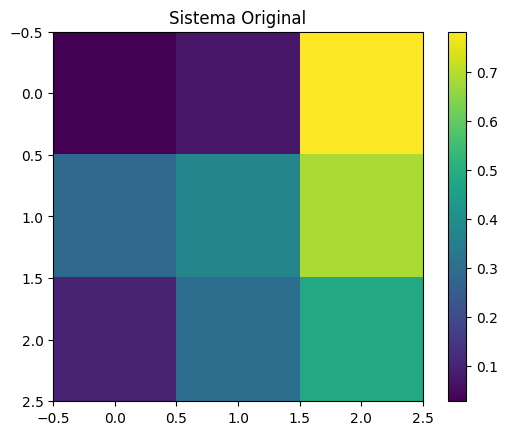

In [52]:
import matplotlib.pyplot as plt

# Visualizar el sistema original
plt.imshow(original_system, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Sistema Original")
plt.show()
